Temperature Interpolation

High-level goals:
    
    Primary:
        Create a shapefile that represents real-time temperature throughout the White Mountain region
        Quantify uncertainty of temperature readings in the above shapefile
        Create a graph of elevation and temperature of the Mount Washington Observatory mesonet sites
    Secondary:
        Expand to forecasting using Plymouth State's WRF output
        Add hiking trail shapes in the White Mountains

First option:
    
    - Calculate sea-level-normalized temperature for each site
    - Interpolate this sea-level temperature across study area using a combination of linear (for values inside perimeter of data) and nearest interpolation
    - Use a Digital Elevation Model to deterimine the height-adjusted temperature at each pixel
    
    Data sets to be used:
        1/3 arc-second DEM model
        Mount Washington Observatory mesonet data
    

Second option:

    - Using readings from all mesonet sites, use regression to determine dT/dH at all heights in the study area.
    - Apply a linear or cubic interpolation across the study area to determine a proximity weighting for each site.
    - At each pixel on a digital elevation model, calculate the temperature based on the regression model using the proximity weighting (eg weighting closer sites more heavily).

    Data sets to be used:
        1/3 arc-second DEM model
        Mount Washington Observatory mesonet data

Third option:

    - Download the Real-Time Mesoscale Analysis dataset (contains low-resolution surface temperature)
    - Determine a valid "sphere of influence" for each mesonet site
    - Correct the Real-Time Mesoscale Analysis based on this sphere of influence
    
    Data sets to be used:
        1/3 arc-second DEM model
        Mount Washington Observatory mesonet data
        Real-Time Mesoscale Analysis; New England
        

See configuration cell below for details about data set locations.

Perform blocks in parallel:

    for site in sites:
        Download 5-minute data    
        Append data to regional dataframe
    With regional dataframe:
        Calculate sea-level-normalized temperature for each site
        Write sea-level-normalized temperature to dataframe

    Download elevation data
    With elevation data:
        With rasterio, load into raster
        Downscale as necessary
    
    Download RAP data (optional)


With elevation numpy array:
    
    Create new np array with the same dimensions as the elevation data  
    Use a linear (or other) interpolation method on sea-level-normalized temperature at each pixel  
    Optionally correct/weight points far away from sensors with sea-level-normalized RAP data  
    Print numpy array to raster output (optional for debugging)  
    numpy array calculation; use sea-level temperature and altitude arrays to determine surface temperature at each pixel
    Print temperature array to raster output (final output)  
    Print an uncertainty array  
    Upload outputs to S3  
  
    
    
  

In [1]:
import json
import os
import urllib.request
import zipfile

import geopandas as gp
from matplotlib import pyplot as plt
import metpy.calc
from metpy.units import units
import numpy as np
import pandas as pd
import pint
import pygrib
import rasterio
from rasterio.features import shapes
import scipy.interpolate


In [2]:
# Configuration
cwd = os.getcwd()

MESONET_DATA_URL = "http://xmountwashington.appspot.com/mmNew.php?callback=null"

TARGET_DEM_URL = "https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/ArcGrid/USGS_NED_13_n45w072_ArcGrid.zip"
TARGET_DEM_FILE_ZIP = os.path.join(cwd, "tmp/dem.zip")
TARGET_DEM_FILE_UNZIP = os.path.join(cwd, "data/dem")
TARGET_DEM_DATA_FILE = os.path.join(TARGET_DEM_FILE_UNZIP, "grdn45w072_13", "w001001.adf")

RTMA_URL_PREFIX = "ftp://ftp.ncep.noaa.gov/pub/data/nccf/com/rtma/prod/"
TARGET_RTMA_DIR = os.path.join(cwd, "data/RTMA")

TARGET_SHAPEFILE_OUTPUT_DIR = os.path.join(cwd, "results/shapes")
DEFAULT_SHAPEFILE_OUTPUT_FNAME = os.path.join(TARGET_SHAPEFILE_OUTPUT_DIR, "results.shp")

# A ratio of number-of-datapoints-in-input-dem to number-of-datapoints-in-output
# This value must be less than 1.  1 would achieve the highest possible resolution but result in the longest compute times
OUTPUT_RESOLUTION = 1/10

In [3]:
def make_item(json):
    '''
    Takes a json object and creates an items' dataframe.  This will hopefully be replaced with a simple 
    json loading call at some point.  Should be as simple as pd.read_json once we figure out the 
    callback issue eg pd.read_json('http://xmountwashington.appspot.com/mmNew.php')
    '''
    df = pd.DataFrame(columns=["siteName", "siteLat", "siteLon", "siteAltitude", "temperature", "potential_temperature", "pressure"])
    for site in json:
        if "temperature" in json[site]:
            df = df.append({"siteName": site, 
                            "siteLat": json[site]["latitude"],
                            "siteLon": json[site]["longitude"],
                            "siteAltitude": units.meters,
                            "temperature": float(json[site]["temperature"]) * units.degF,
                            "potential_temperature": units.degF,
                            "pressure": None
                           }, 
                           ignore_index=True)
    populate_alt_from_dem(df)
    return df


def populate_alt_from_dem(df, file=TARGET_DEM_DATA_FILE):
    '''
    With a given dataframe that has a "siteAltitude" column, populate based
    on the data from the provided DEM file.
    '''
    with rasterio.open(file) as dem:
        dem_arr = np.squeeze(dem.read())
        for i, row in df.iterrows():
            site_y_pixel, site_x_pixel = dem.index(row["siteLon"], row["siteLat"])    
            df.at[i, 'siteAltitude'] = dem_arr[site_y_pixel][site_x_pixel] * units.meters
    
    
def get_potential_temperature(df):
    '''
    Populate the potential_temperature column of the dataframe.  If the pressure column is present,
    this pressure value is used to determine potential temperature.  Otherwise, 
    '''
    for i, row in df.iterrows():
        if row["pressure"] is None:
            pressure = metpy.calc.height_to_pressure_std(row["siteAltitude"])
            
            # Since it's not present, add it
            df.at[i, 'pressure'] = pressure
        else:
            pressure = row["pressure"]
            
        if "dewpoint" in row:
            # calculate equivalent potential temperature
            potential_temperature = metpy.calc.equivalent_potential_temperature(pressure, row["temperature"], row["dewpoint"])
        else:
            # calculate potential temperature
            potential_temperature = metpy.calc.potential_temperature(pressure, row["temperature"])
        
        # Add the potential temperature
        df.at[i,'potential_temperature'] = potential_temperature
        
        

In [4]:
def download_file(url, target, clobber=False):
    '''
    Download the specified file to the target, optionally clobbering the existing file.
    Works with both https and ftp protocols.  Creates target directory if it doesn't
    already exist.
    '''
    _make_dirs_if_no_exists(target)
    print("Downloading file %s" % url)
    if os.path.exists(target) and not clobber:
        print("Path %s already exists; using previoiusly downloaded file." % target)
        return False
    urllib.request.urlretrieve(url, target)  
    return True

        
def extract_file(source, target, delete_source=False):
    '''
    Extract given file from the source to the target and optionally deletes the source.
    Creates target directory if it doesn't already exist.  Note - deleting the source 
    will result in the file being downloaded again if things are run again.
    '''
    _make_dirs_if_no_exists(target)
    print("Unzipping file %s to %s." % (source, target))
    with zipfile.ZipFile(source,"r") as zip_ref:
        zip_ref.extractall(target)
    

def _make_dirs_if_no_exists(dirname):
    '''
    Attempt to make a directory if it doesn't exist already.
    '''
    if not os.path.exists(os.path.dirname(dirname)):
        print("Path %s does not exist.  Attempting to make it now." % os.path.dirname(dirname))
        os.makedirs(os.path.dirname(dirname))

In [5]:
def raster_to_shape(arr, transform, fname=DEFAULT_SHAPEFILE_OUTPUT_FNAME):
    '''
    Generate a shape from a raster that has common values.
    NOTE; IF AN ARRAY WITH MANY UNIQUE VALUES IS PASSED IN, THIS FUNCTION WILL RUN VERY SLOWLY
    
    Parameters
    arr: numpy array
        The numpy array which contains the data you would like to generate shapes from.
        
    transform: Affine
        The transformation from array indices to geographic coordinates
    
    fname: string
        The file name for the output.  Folders will be created if they don't exist
    '''
    _make_dirs_if_no_exists(fname)
    results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) 
        in enumerate(
            shapes(arr, transform=transform)))
    
    gdf = gp.GeoDataFrame.from_features(list(results))
    gdf.to_file(driver = 'ESRI Shapefile', filename = fname)
    return gdf

In [6]:
# Driver for download and extraction of DEM data
# Must occur first so altitude data can be determined in the mesonet dataframe

if download_file(TARGET_DEM_URL, TARGET_DEM_FILE_ZIP):
    extract_file(TARGET_DEM_FILE_ZIP, TARGET_DEM_FILE_UNZIP)

Path /external/mesonet-interpolation/temperature/tmp/dem.zip already exists; using previoiusly downloaded file.


In [7]:
# Driver for downloading mesonet data and performing point calculations (eg calculating potential temperature)

with urllib.request.urlopen(MESONET_DATA_URL) as response:
    callback = response.read()
json_string = callback.decode("utf8").rstrip(')').lstrip('null(')
mesonet_data = json.loads(json_string)
df = make_item(mesonet_data['currentMesonetConditions'])
get_potential_temperature(df)


# Option 1 (see above for description)

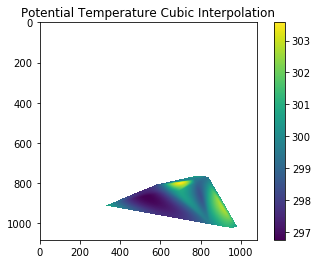

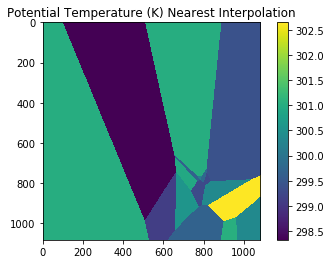

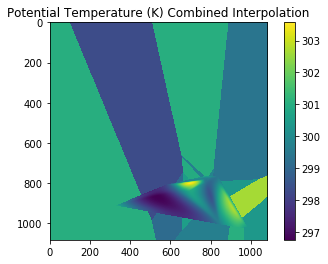

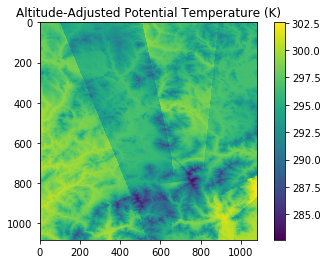

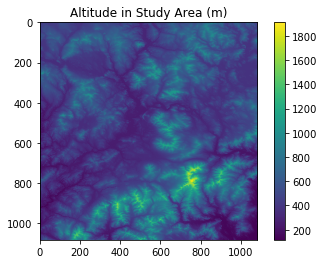

In [8]:
# Driver that combines mesonet and DEM data

with rasterio.open(TARGET_DEM_DATA_FILE) as dem:
    # Downscaling our output data so we don't have the same resolution as the DEM data
    # This can likely be done in a more elegant way
    output_res_step = int(1/OUTPUT_RESOLUTION)
    x = np.arange(0, dem.width, output_res_step)
    y = np.arange(0, dem.height, output_res_step)
    X, Y = np.meshgrid(x,y)
    
    dem_arr = dem.read()
    dem_arr = np.squeeze(dem_arr)
    condensed_altitudes = dem_arr[0:dem.height:output_res_step, 0:dem.width:output_res_step]
    
    x_pixels = []
    y_pixels = []
    values = []
    
    # Iterate over the dataframe rows and append to the list of values/indices in the output
    # This can likely be vectorized and made more efficient
    for i, row in df.iterrows():
        site_y_pixel, site_x_pixel = dem.index(row["siteLon"], row["siteLat"])    
        x_pixels.append(site_x_pixel)
        y_pixels.append(site_y_pixel)
        values.append(row["potential_temperature"].magnitude)
    
    # Note - a cubic interpolation doesn't know what to do with data outside the perimeter
    potential_temperature_interpolated_cubic = scipy.interpolate.griddata((np.asarray(x_pixels), np.asarray(y_pixels)), np.asarray(values), (X, Y), method="cubic")
    plt.imshow(potential_temperature_interpolated_cubic)
    plt.title("Potential Temperature Cubic Interpolation")
    plt.colorbar()
    plt.show()
    
    # Note - a nearest interpolation...isn't smooth
    potential_temperature_interpolated_nearest = scipy.interpolate.griddata((np.asarray(x_pixels), np.asarray(y_pixels)), np.asarray(values), (X, Y), method="nearest")
    plt.imshow(potential_temperature_interpolated_nearest)
    plt.title("Potential Temperature (K) Nearest Interpolation")
    plt.colorbar()
    plt.show()

    # The best of both worlds - a cubic interpolation where it can be made, filled in with nearest where it can't
    potential_temperature_interpolated_combination = potential_temperature_interpolated_cubic
    potential_temperature_interpolated_combination[np.isnan(potential_temperature_interpolated_combination)] = potential_temperature_interpolated_nearest[np.isnan(potential_temperature_interpolated_combination)]
    plt.imshow(potential_temperature_interpolated_combination)
    plt.title("Potential Temperature (K) Combined Interpolation")
    plt.colorbar()
    plt.show()

    # Now that we have altitude and potential temperature, calculate pressure at the given altitude then bring our temperatures up to that pressure
    pressure = metpy.calc.height_to_pressure_std(condensed_altitudes * units.meters)
    temperature = metpy.calc.temperature_from_potential_temperature(pressure, potential_temperature_interpolated_combination * units.degK)
    
    # Note the extremely high altitude correlation
    # This is likely not physical
    plt.imshow(temperature)
    plt.title("Altitude-Adjusted Potential Temperature (K)")
    plt.colorbar()
    plt.show()
    
    # Showing altitude for reference
    plt.imshow(condensed_altitudes)
    plt.title("Altitude in Study Area (m)")
    plt.colorbar()
    plt.show()
    

In [9]:
# Calculating temperature differences between site temperature and height-adjusted potential temperature
# These values should be _very_ small since we just performed an equation, then the inverse at this location
for i, row in df.iterrows():
    x_pixel_output = x_pixels[i] * OUTPUT_RESOLUTION
    y_pixel_output = y_pixels[i] * OUTPUT_RESOLUTION
    site_temperature_output = temperature[int(y_pixel_output), int(x_pixel_output)]
    temperature_diff = site_temperature_output.to(units.degF) - row["temperature"]
    print("Temperature difference for %s: %s" % (row["siteName"], str(temperature_diff)))

Temperature difference for AR16: 0.03262042126856102 delta_degF
Temperature difference for AR23: -0.5541393049516472 delta_degF
Temperature difference for AR33: 0.14037982149002914 delta_degF
Temperature difference for AR40: 0.22327991668475278 delta_degF
Temperature difference for AR43: 0.20058480029950232 delta_degF
Temperature difference for AR53: 0.38380905652015684 delta_degF
Temperature difference for ATTI: 0.28362982953761673 delta_degF
Temperature difference for BRWD: 0.18656497549395112 delta_degF
Temperature difference for CANN: 0.12867996913976043 delta_degF
Temperature difference for CRAN: 0.09116341735419553 delta_degF
Temperature difference for HICR: 0.1353766218188639 delta_degF
Temperature difference for JACK: 0.03680580106689035 delta_degF
Temperature difference for MIZP: -0.4514377792277884 delta_degF
Temperature difference for SUMT: 0.34384287107000944 delta_degF
Temperature difference for TUCK: 0.05119462832989541 delta_degF
Temperature difference for WILD: -0.04798

# General Observations for Option 1

- A combination of nearest (which extrapolates outside the boundary of the site to the rest of the region) and linear/cubic (which is much smoother, but only interpolates inside the outer boundary of sites) is necessary.
- Adding a smoothing algorithm may make sense to avoid sharp lines where the nearest extrapolation is used.
- While it doesn't lead to completely unreasonable values, the result is extremely correlated to elevation and may not be physically realistic.   

# Option 2 (see above for description)
The input data frame from option 1 above will be used (although some columns specific to option 1 will be ignored).  The same input DEM file will also be used.

# Option 3 (see above for description)
The input data frame from option 1 above will be used (although some columns specific to option 1 will be ignored).  The same input DEM file will also be used.

In [10]:
# Driver for download and reading of RTMA model data

# TODO; pull from the DEM file instead (these values should match or be slightly greater than the DEM boundaries)
# Ultimately, we'll want to clip all our data sets based on our study area as well as converting them all to the same coordinate system and resolution
minRAPLat = 43.5
maxRAPLat = 45.5
minRAPLon = -72.5
maxRAPLon = -69.5

# TODO; grab newest RTMA file
RTMA_URL_FILE = "rtma2p5_ru.20190714/rtma2p5_ru.t0000z.2dvaranl_ndfd.grb2"
RTMA_URL = os.path.join(RTMA_URL_PREFIX, RTMA_URL_FILE)

TARGET_RTMA_FILE = os.path.join(TARGET_RTMA_DIR, "rtma2p5_ru.20190714/rtma2p5_ru.t0000z.2dvaranl_ndfd.grb2")

def examine_file(grbs):
    '''
    A helper function that prints out the contents of a grib file
    '''
    grbs.seek(0)
    for grb in grbs:
        print(grb)

_ = download_file(RTMA_URL, TARGET_RTMA_FILE)
with pygrib.open(TARGET_RTMA_FILE) as grbs:
    rtma_t_msg = grbs.select(name='2 metre temperature')[0]
    rtma_t_data, rtma_t_lats, rtma_t_lons = rtma_t_msg.data(lat1=minRAPLat, lat2=maxRAPLat, lon1=minRAPLon, lon2=maxRAPLon)
    
    # In case you're curious about the contents of the RTMA file
    examine_file(grbs)
    


Path /external/mesonet-interpolation/temperature/data/RTMA/rtma2p5_ru.20190714/rtma2p5_ru.t0000z.2dvaranl_ndfd.grb2 already exists; using previoiusly downloaded file.
1:Orography:m (instant):lambert:surface:level 0:fcst time 0 mins:from 201907140000
2:Surface pressure:Pa (instant):lambert:surface:level 0:fcst time 0 mins:from 201907140000
3:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 0 mins:from 201907140000
4:2 metre dewpoint temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 0 mins:from 201907140000
5:10 metre U wind component:m s**-1 (instant):lambert:heightAboveGround:level 10 m:fcst time 0 mins:from 201907140000
6:10 metre V wind component:m s**-1 (instant):lambert:heightAboveGround:level 10 m:fcst time 0 mins:from 201907140000
7:Specific humidity:kg kg**-1 (instant):lambert:heightAboveGround:level 2 m:fcst time 0 mins:from 201907140000
8:10 metre wind direction:Degree true (instant):lambert:heightAboveGround:level 10 m:fcst tim

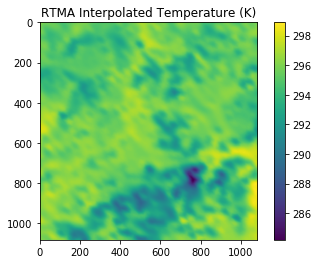

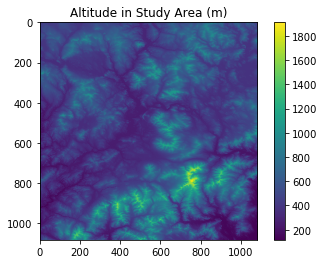

In [11]:
# Driver that interpolates Real-Time Mesoscale Analysis data
# Ultimately this can be simplified vastly.  There is no need to open the DEM file here - I'm just using it as a crutch
# so I can easily translate from coordinate-land to pixel-land.

with rasterio.open(TARGET_DEM_DATA_FILE) as dem:
    output_res_step = int(1/OUTPUT_RESOLUTION)
    
    dem_arr = dem.read()
    dem_arr = np.squeeze(dem_arr)
    condensed_altitudes = dem_arr[0:dem.height:output_res_step, 0:dem.width:output_res_step]
    
    x = np.arange(0, dem.width, output_res_step)
    y = np.arange(0, dem.height, output_res_step)
    X, Y = np.meshgrid(x,y)
    
    x_pixels = []
    y_pixels = []
    values = []
    
    # SLOW. TODO: vectorize this.
    for i in range(0, rtma_t_data.size):
        site_y_pixel, site_x_pixel = dem.index(rtma_t_lons[i], rtma_t_lats[i])    
        x_pixels.append(site_x_pixel)
        y_pixels.append(site_y_pixel)
        values.append(rtma_t_data[i])
        
    rtma_t_interpolated_cubic = scipy.interpolate.griddata((np.asarray(x_pixels), np.asarray(y_pixels)), np.asarray(values), (X, Y), method="cubic")
    plt.imshow(rtma_t_interpolated_cubic)
    plt.title("RTMA Interpolated Temperature (K)")
    plt.colorbar()
    plt.show()
    
    plt.imshow(condensed_altitudes)
    plt.title("Altitude in Study Area (m)")
    plt.colorbar()
    plt.show()
    
    dem_transform = dem.transform
    

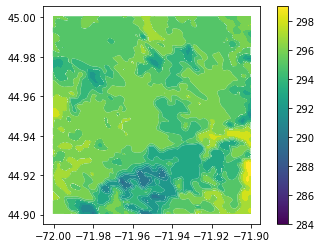

In [13]:
polygonized_arr = rtma_t_interpolated_cubic.astype(np.float32)
polygonized_arr = np.round(polygonized_arr)
gpd_df = raster_to_shape(polygonized_arr, dem_transform)

# Be aware - this plot has overlapping shapes, so things may not display correctly
# I recommend pulling the files from DEFAULT_SHAPEFILE_OUTPUT_FNAME and viewing them
# in an external, interactive viewer instead
gpd_df.plot(column="raster_val", legend=True)
plt.show()

# General Observations for Option 3
 - Out of all options above, this is the only option that includes external-to-altitude-and-lat-lon physical considerations in the output (with the inclusion of the RTMA data).
 - The additional file dependency adds complication to the whole process.